# Aggregating and Visualizing Reddit RSS Data

Now that we have extracted post data from the top 25 subreddits by subscriber count, we're going to do some data carpentry on it. Along with this data carpentry, we'll be building some data visualizations as well in order to look at some high level trends.

Below is a picture used for reference for subscriber counts for these subreddits. We'll use this picture to create a table that was not created during the ETL process (since as far as I am aware Reddit offers no easy way to get real time subreddit subscriber numbers via RSS feeds) that will help us look at some relationships.

![TopSubreddits5.2.2020.PNG](img/TopSubreddits5.2.2020.PNG)

## Table of Contents

- Data Carpentry
- Aggregated Tables
- Visualizations

### Data Carpentry

Here are the following steps to our data carpentry:

1. Load in our data and our package dependancies
2. Convert our datetime field into a date field and a timestamp field
3. Create a subscribers dataframe

We will use stringsAsFactors=FALSE because we are loading in titles for our post, which is blob data. Since reddit assigns all character variables to factors, this would make using this field harder. Also, we can convert the things that are factors (like subreddits or users) back into factors later if necessary. This will also load in the datetime as a character field which we'll easily convert to a date field. We'll separate our date and our time into two different fields. This will help analysts as they can easily aggregate by day/month/year or time of day without having to do any data cleaning themselves.

In [1]:
library(dplyr)
library(ggplot2)
library(lubridate)

df <- read.csv("results/flattened_sentiment_analysis.csv")
head(df)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



post_id,subreddit,author,datetime,title,sentiment_score,sentiment_magnitude,num_entities
<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>
1001,funny,/u/the_Diva,2017-12-28T03:00:55+00:00,My cab driver tonight was so excited to share with me that he’d made the cover of the calendar. I told him I’d help let the world see,0.3,0.7,4
1002,funny,/u/iH8myPP,2016-12-05T17:41:14+00:00,Guardians of the Front Page,0.0,0.0,2
1003,funny,/u/namraka,2017-10-03T20:10:50+00:00,Gas station worker takes precautionary measures after customer refused to put out his cigarette,-0.8,0.8,4
1004,funny,/u/Romobyl,2017-12-19T19:24:04+00:00,The conversation my son and I will have on Christmas Eve.,0.1,0.1,3
1005,funny,/u/System32Comics,2019-09-10T18:25:47+00:00,Printers,0.1,0.1,1
1006,funny,/u/iH8myPP,2017-07-29T12:56:39+00:00,Reddit's Immigrants,0.2,0.2,2


In [2]:
df$date <-  as.Date(df$datetime,"%Y-%m-%d")
df$datetime <- NULL
head(df)

post_id,subreddit,author,title,sentiment_score,sentiment_magnitude,num_entities,date
<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<date>
1001,funny,/u/the_Diva,My cab driver tonight was so excited to share with me that he’d made the cover of the calendar. I told him I’d help let the world see,0.3,0.7,4,2017-12-28
1002,funny,/u/iH8myPP,Guardians of the Front Page,0.0,0.0,2,2016-12-05
1003,funny,/u/namraka,Gas station worker takes precautionary measures after customer refused to put out his cigarette,-0.8,0.8,4,2017-10-03
1004,funny,/u/Romobyl,The conversation my son and I will have on Christmas Eve.,0.1,0.1,3,2017-12-19
1005,funny,/u/System32Comics,Printers,0.1,0.1,1,2019-09-10
1006,funny,/u/iH8myPP,Reddit's Immigrants,0.2,0.2,2,2017-07-29


In [3]:
subreddit <- c("funny","AskReddit","gaming","pics","aww","science","worldnews","Music","movies","videos",
              "todayilearned","news","IAmA","gifs","Showerthoughts","EarthPorn","askscience","Jokes","food",
              "explainlikeimfive","books","LifeProTips","Art","mildlyinteresting","DIY")

subscribers <- c(29287480,26971071,25496419,24129496,23969181,23563518,23464098,22872171,22509990,22403840,
                22380697,20147775,19886688,19689386,19618434,19483325,18798540,18044919,18007713,17748919,17696504,
                 17461439,17238029,17221530,17149341)

extract_date <- Sys.Date() #2020-05-03

subs_df <- data.frame(subreddit,subscribers,extract_date,stringsAsFactors=FALSE)

head(subs_df)

subreddit,subscribers,extract_date
<chr>,<dbl>,<date>
funny,29287480,2020-05-03
AskReddit,26971071,2020-05-03
gaming,25496419,2020-05-03
pics,24129496,2020-05-03
aww,23969181,2020-05-03
science,23563518,2020-05-03


### Aggregated Tables

Now that we've done a bit of data carpentry, we'll start creating our aggregated tables. The tables we'll create are:

- Average Sentiment and Entity Information for each Subreddit in the top 25 by subscriber count
- Posts per Month/Year from the top 100 posts from each Subreddit in the top 25 by subscriber count
- Users with the most posts across the top 100 posts from each Subreddit in the top 25 by subscriber count

These are just a few tables we'll start with which we can create multiple visualizations out of.

In [4]:
table1 <- df %>%
    group_by(subreddit) %>%
    summarize_at(c("sentiment_score","sentiment_magnitude","num_entities"),mean,na.rm=TRUE) %>%
    left_join(subs_df,by=c("subreddit"="subreddit"))

head(table1)

Warning message:
“Column `subreddit` joining factor and character vector, coercing into character vector”

subreddit,sentiment_score,sentiment_magnitude,num_entities,subscribers,extract_date
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
Art,0.149,0.218,4.17,17238029,2020-05-03
AskReddit,-0.028,0.345,4.48,26971071,2020-05-03
askscience,-0.151,0.359,4.96,18798540,2020-05-03
aww,0.187,0.525,3.51,23969181,2020-05-03
books,-0.109,0.395,5.63,17696504,2020-05-03
DIY,0.217,0.494,3.67,17149341,2020-05-03


In [5]:
post_per_month <- df %>%
    group_by(month=floor_date(date,"month")) %>%
    summarize(posts = n())

avg_nlp <- df %>%
    group_by(month=floor_date(date,"month")) %>%
    summarize_at(c("sentiment_score","sentiment_magnitude","num_entities"),mean,na.rm=TRUE)

table2 <- post_per_month %>%
    left_join(avg_nlp,by=c("month"="month"))

head(table2)

month,posts,sentiment_score,sentiment_magnitude,num_entities
<date>,<int>,<dbl>,<dbl>,<dbl>
2012-08-01,1,0.00,0.0,3.0
2014-07-01,2,0.40,0.8,7.5
2014-08-01,1,0.00,0.0,2.0
2014-10-01,2,0.05,0.1,2.0
2014-12-01,1,0.10,0.1,3.0
2015-01-01,2,0.00,0.0,3.0


In [6]:
posts_by_year <- df %>%
    group_by(year=floor_date(date,"year")) %>%
    summarize(posts = n())

avg_nlp <- df %>%
    group_by(year=floor_date(date,"year")) %>%
    summarize_at(c("sentiment_score","sentiment_magnitude","num_entities"),mean,na.rm=TRUE)

table3 <- posts_by_year %>%
    left_join(avg_nlp,by=c('year'='year'))

head(table3,10)

year,posts,sentiment_score,sentiment_magnitude,num_entities
<date>,<int>,<dbl>,<dbl>,<dbl>
2012-01-01,1,0.00000000,0.0000000,3.000000
2014-01-01,6,0.16666667,0.3166667,4.000000
2015-01-01,22,0.08636364,0.4772727,4.954545
2016-01-01,83,0.04337349,0.3674699,4.518072
2017-01-01,593,0.01568297,0.4794266,4.750422
2018-01-01,703,0.02745377,0.4344239,4.847795
2019-01-01,722,0.04930748,0.4728532,5.304709
2020-01-01,370,-0.01405406,0.4081081,5.275676


In [7]:
posts_by_user <- df %>%
    group_by(author) %>%
    summarize(total_posts = n()) %>%
    arrange(desc(total_posts))

head(posts_by_user)

author,total_posts
<fct>,<int>
,67
/u/mvea,39
/u/BunyipPouch,20
/u/maxwellhill,8
/u/SAT0725,8
/u/Wagamaga,8


### Visualizations

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


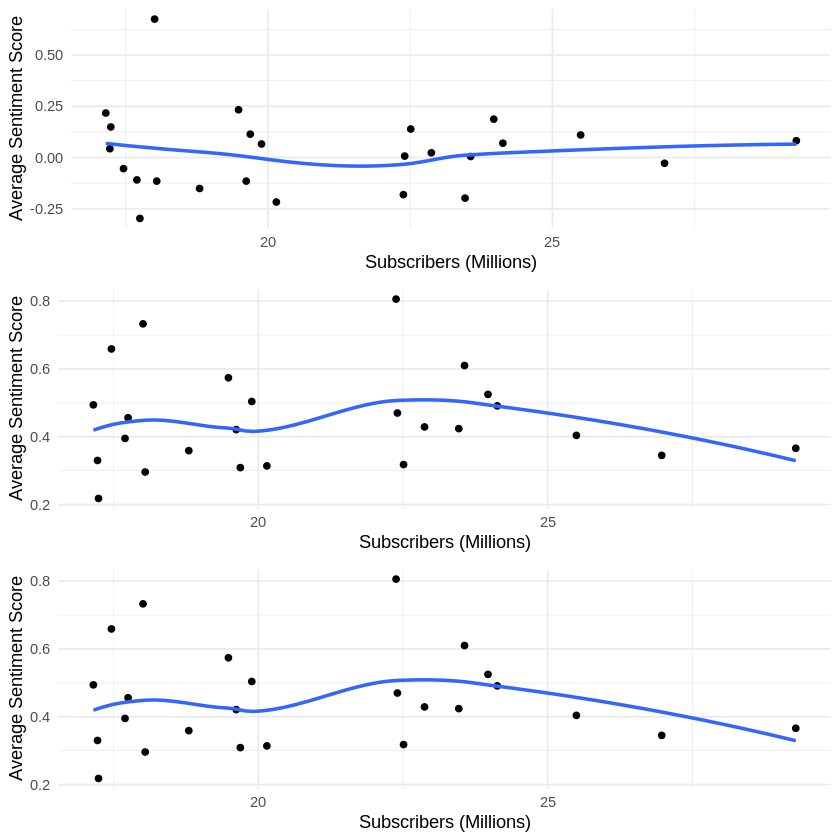

In [8]:
#needs to be run in data viz container for the following packages...
library(ggthemes)
library(grid)

#sentiment score plot
plot1_score <- ggplot(table1,aes(x=subscribers/1000000,y=sentiment_score))
plot1_score <- plot1_score + geom_point()
plot1_score <- plot1_score + geom_smooth(se=FALSE)
plot1_score <- plot1_score + xlab("Subscribers (Millions)")
plot1_score <- plot1_score + ylab("Average Sentiment Score")
plot1_score <- plot1_score + theme_minimal()

#sentiment magnitude
plot1_magnitude <- ggplot(table1,aes(x=subscribers/1000000,y=sentiment_magnitude))
plot1_magnitude <- plot1_magnitude + geom_point()
plot1_magnitude <- plot1_magnitude + geom_smooth(se=FALSE)
plot1_magnitude <- plot1_magnitude + xlab("Subscribers (Millions)")
plot1_magnitude <- plot1_magnitude + ylab("Average Sentiment Score")
plot1_magnitude <- plot1_magnitude + theme_minimal()

#number of entities
plot1_entities <- ggplot(table1,aes(x=subscribers/1000000,y=sentiment_magnitude))
plot1_entities <- plot1_entities + geom_point()
plot1_entities <- plot1_entities + geom_smooth(se=FALSE)
plot1_entities <- plot1_entities + xlab("Subscribers (Millions)")
plot1_entities <- plot1_entities + ylab("Average Sentiment Score")
plot1_entities <- plot1_entities + theme_minimal()

pushViewport(viewport(layout = grid.layout(3, 1)))
print(plot1_score, vp = viewport(layout.pos.row = 1, layout.pos.col = 1))
print(plot1_magnitude, vp = viewport(layout.pos.row = 2, layout.pos.col = 1))
print(plot1_entities, vp = viewport(layout.pos.row = 3, layout.pos.col = 1))

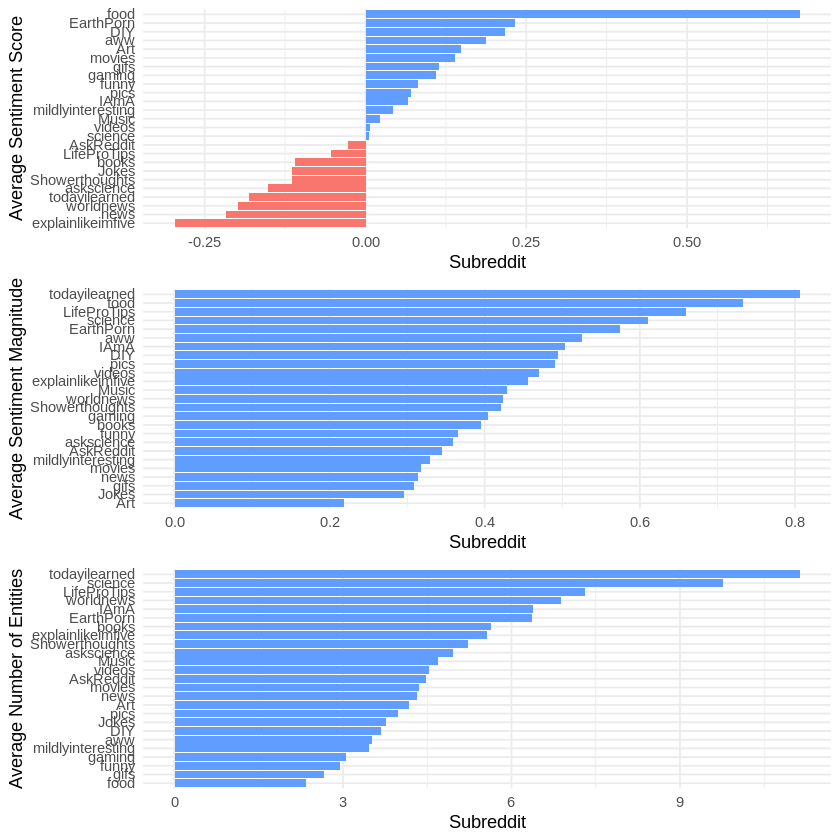

In [9]:
table1$colour = ifelse(table1$sentiment_score<0, "negative","positive")

bar1_score <- ggplot(table1,aes(x=reorder(subreddit,sentiment_score),y=sentiment_score,fill=colour))
bar1_score <- bar1_score + geom_bar(stat = "identity")
bar1_score <- bar1_score + scale_fill_manual(values=c(positive="#619CFF",negative="#F8766D"))
bar1_score <- bar1_score + coord_flip()
bar1_score <- bar1_score + xlab("Average Sentiment Score")
bar1_score <- bar1_score + ylab("Subreddit")
bar1_score <- bar1_score + theme_minimal()
bar1_score <- bar1_score + theme(legend.position="none")

bar1_magnitude <- ggplot(table1,aes(x=reorder(subreddit,sentiment_magnitude),y=sentiment_magnitude))
bar1_magnitude <- bar1_magnitude + geom_bar(stat = "identity",fill="#619CFF")
bar1_magnitude <- bar1_magnitude + coord_flip()
bar1_magnitude <- bar1_magnitude + xlab("Average Sentiment Magnitude")
bar1_magnitude <- bar1_magnitude + ylab("Subreddit")
bar1_magnitude <- bar1_magnitude + theme_minimal()

bar1_entities <- ggplot(table1,aes(x=reorder(subreddit,num_entities),y=num_entities))
bar1_entities <- bar1_entities + geom_bar(stat = "identity",fill="#619CFF")
bar1_entities <- bar1_entities + coord_flip()
bar1_entities <- bar1_entities + xlab("Average Number of Entities")
bar1_entities <- bar1_entities + ylab("Subreddit")
bar1_entities <- bar1_entities + theme_minimal()

pushViewport(viewport(layout = grid.layout(3, 1)))
print(bar1_score, vp = viewport(layout.pos.row = 1, layout.pos.col = 1))
print(bar1_magnitude, vp = viewport(layout.pos.row = 2, layout.pos.col = 1))
print(bar1_entities, vp = viewport(layout.pos.row = 3, layout.pos.col = 1))